In [1]:
import os
import pandas as pd
import numpy as np
from GAE.custom_layers import ConvTypes
from GAE.LossManager import LossTypes, LossManager
import scikit_posthocs as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from GAE.utils import *
import operator
import pickle 
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import re 

from FramsticksLib import *
import subprocess
from scipy.spatial import distance

DATA_OUT = 'plots/'

In [103]:
## multi_layers for gcs
# path_models = "/home/adam/thesis/VGAE/experiments/experiment_multi_layers/models/"
# path_configs = "/home/adam/thesis/VGAE/experiments/experiment_multi_layers/models/No/configs/"
# model_names = "gcs_diff_layers"

## base_all 
path_models = "/home/adam/thesis/VGAE/experiments/experiment_base/models/"
path_configs = "/home/adam/thesis/VGAE/experiments/experiment_base/models/No/configs/"
model_names = "base_all_convtypes"

## joints
# path_models = "/home/adam/thesis/VGAE/experiments/experiment_base/models/"
# path_configs = "/home/adam/thesis/VGAE/experiments/experiment_base/models/joints/configs/"
# model_names = "base_joints"


#### LOCALITY LOSS:
#all
# path_models = "/home/adam/thesis/VGAE/experiments/experiment_base/models/"
# path_configs = "/home/adam/thesis/VGAE/experiments/experiment_base/configs_all/"
# model_names = "locality_all_convtypes"


#parts
# path_models = "/home/adam/thesis/VGAE/experiments/experiment_base/models/"
# path_configs = "/home/adam/thesis/VGAE/experiments/experiment_base/models/joints/configs/"
# model_names = "locality_joints_convtypes"

#fitness
# path_models = "/home/adam/thesis/VGAE/experiments/experiment_base/models/"
# path_configs = "/home/adam/thesis/VGAE/experiments/experiment_base/models/fitness/configs/"
# model_names = "locality_fitness_convtypes"

#dissim 
# path_models = "/home/adam/thesis/VGAE/experiments/experiment_base/models/"
# path_configs = "/home/adam/thesis/VGAE/experiments/experiment_base/models/dissim/configs/"
# model_names = "locality_dissim_convtypes"

##VERTPOS
# path_models = "/home/adam/thesis/VGAE/experiments/experiment_vertpos/models_vertpos/"
# path_configs = "/home/adam/thesis/VGAE/experiments/experiment_vertpos/models_vertpos/configs/"
# model_names = "vertpos_all"


In [124]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [105]:
pathframs = "/home/adam/Framsticks/Framsticks50rc19"
framsmanager = FramsManager(pathframs)

framsLib = FramsticksLib(pathframs,None,["/home/adam/thesis/VGAE/framspy/eval-allcriteria_new.sim"])


Using Framsticks version: 5.0rc19.1
Home (writable) dir     : /home/adam/Framsticks/Framsticks50rc19/data
Resources dir           : /home/adam/Framsticks/Framsticks50rc19/data

Using Framsticks version: 5.0rc19.1
Home (writable) dir     : /home/adam/Framsticks/Framsticks50rc19/data
Resources dir           : /home/adam/Framsticks/Framsticks50rc19/data

Available objects: ['CheckpointEvent', 'Collision', 'CrCollision', 'Creature', 'CreatureSettings', 'CreatureSignals', 'CreatureSnapshot', 'Dictionary', 'ExpProperties', 'ExpState', 'ExtValue', 'File', 'FunctionReference', 'GenMan', 'GenManStats', 'GenePool', 'GenePools', 'Geno', 'Genotype', 'Interface', 'Joint', 'Loader', 'Math', 'MechJoint', 'MechPart', 'MessageCatcher', 'Model', 'ModelGeometry', 'ModelSymmetry', 'Neuro', 'NeuroClass', 'NeuroClassLibrary', 'NeuroDef', 'NeuroSignals', 'NeuronsSimEnabled', 'ODE', 'Orient', 'Part', 'Population', 'Populations', 'Ref', 'Signal', 'SignalView', 'SimilMeasure', 'SimilMeasureDistribution', 'Simil

In [106]:
def get_convType(name):
    if name =="gcnconv":
        return "GCNConv"
    elif name =="armaconv":
        return "ARMAConv"
    elif name =="eccconv":
        return "ECCConv"
    elif name =="gatconv":
        return "GATConv"
    elif name =="gcsconv":
        return "GCSConv"
    
def get_Loss(name):
    if name =="joints":
        return "joints"
    elif name =="parts":
        return "parts"
    elif name =="fitness":
        return "fitness"
    elif name =="dissim":
        return "dissim"
    elif name =="None":
        return "No"

In [107]:
def load_losses(path):
    losses_all_test = []
    losses_all_train = []
    try:
        with open("{0}/losses_test.npy".format(path), "rb") as infile: 
            losses_all_test = np.load(infile).tolist()
        with open("{0}/losses_train.npy".format(path), "rb") as infile: 
            losses_all_train = np.load(infile).tolist()
#         print("Losses loaded successfully")
    except Exception as e:
        print("Error while loading Losses ", e)
    return losses_all_train, losses_all_test

In [108]:

columns = ["path","name","counter","loss_type","ae_type","convtype","latentdim","nhidden","convenc","denseenc","densedeca","convdecx","densedecx","path_model","losses_all_train", "losses_all_test","loss_train","loss_test"]
all_models= pd.DataFrame(columns=columns )
batchsize = 256
learningrate = 0.01
numfeatures = 3
adjsize = 15
counter = 0
for path, subdirs, files in os.walk(path_configs):
    for file_name in files:
        if "vTrue" in file_name:
            ae_type = "VGAE"
        else:
            ae_type = "GAE"
        splitted = file_name.split("_")
        
        convtype = get_convType(splitted[1])
        latentdim = splitted[2]
        nhidden = splitted[3]
        convenc = splitted[4]
        denseenc = splitted[5]
        densedeca = splitted[6]
        convdecx = splitted[7]
        densedecx = splitted[8]
        loss_type = get_Loss(splitted[9])
        

        for trainid in range(1,11,1):
            path_base = (
                loss_type+
                "/"+ae_type +
                "/numfeatures"+str(numfeatures) +
                "/adjsize"+str(adjsize) + 
                "/batchsize"+str(batchsize) +
                "/latentdim"+str(latentdim)+
                "/nhidden"+str(nhidden)+
                "/learningrate"+str(learningrate)+
                "/convtype"+str(convtype)+
                "/model_enc_"+str(convenc)+"_"+str(denseenc)+
                 "_deca"+str(densedeca)+
                 "_decx"+str(convdecx)+"_"+str(densedecx)+
                 "_train_id_"+str(trainid)
                )
            path_model = str(path_models)+path_base
            
            losses_all_train, losses_all_test = load_losses(path_model)
            loss_train = losses_all_train[-1][1]
            loss_test = losses_all_test[-1][1]
            name = file_name.split("_")
#             print(name)
#             break
            f = operator.itemgetter(4,5,6,7,8)
            sublist = list(f(name))
#             print(sublist)
#             new_name = "d:{0} c:{1}".format(sublist[0],sublist[1])
#             new_name = "{0}{1}".format(sublist[0],sublist[1])
            new_name =""
            for e in sublist:
                new_name = new_name+e+"_" 
            name =new_name + ae_type+"_"+loss_type+"_"+latentdim
            data_model = [[path_base,name,counter,loss_type,ae_type,convtype,latentdim,nhidden,convenc,denseenc,densedeca,convdecx,densedecx,path_model,losses_all_train, losses_all_test,loss_train,loss_test]]
            data_model = pd.DataFrame(data_model,columns=columns) 
            all_models = all_models.append(data_model, ignore_index=True)
        counter+=1


In [109]:
all_models.shape

(480, 18)

In [110]:
all_models

,path,name,counter,loss_type,ae_type,convtype,latentdim,nhidden,convenc,denseenc,densedeca,convdecx,densedecx,path_model,losses_all_train,losses_all_test,loss_train,loss_test
0,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,2_2_1_1_2_GAE_No_3,0,No,GAE,GCSConv,3,64,2,2,1,1,2,/home/adam/thesis/VGAE/experiments/experiment_...,"[[1300.00537109375, 1300.00537109375, 0.920543...","[[1441.9046630859375, 1441.9046630859375, 0.87...",882.519531,782.408142
1,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,2_2_1_1_2_GAE_No_3,0,No,GAE,GCSConv,3,64,2,2,1,1,2,/home/adam/thesis/VGAE/experiments/experiment_...,"[[1188.680908203125, 1188.680908203125, 0.9464...","[[1390.06298828125, 1390.06298828125, 0.886633...",733.029907,769.584717
2,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,2_2_1_1_2_GAE_No_3,0,No,GAE,GCSConv,3,64,2,2,1,1,2,/home/adam/thesis/VGAE/experiments/experiment_...,"[[1939.7998046875, 1939.7998046875, 0.87433934...","[[1347.25244140625, 1347.25244140625, 0.869768...",781.569641,753.974854
3,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,2_2_1_1_2_GAE_No_3,0,No,GAE,GCSConv,3,64,2,2,1,1,2,/home/adam/thesis/VGAE/experiments/experiment_...,"[[979.24072265625, 979.24072265625, 0.81581521...","[[1368.4681396484375, 1368.4681396484375, 0.82...",1199.549927,832.958984
4,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,2_2_1_1_2_GAE_No_3,0,No,GAE,GCSConv,3,64,2,2,1,1,2,/home/adam/thesis/VGAE/experiments/experiment_...,"[[1695.597412109375, 1695.597412109375, 0.8174...","[[1401.67041015625, 1401.67041015625, 0.867192...",798.775085,874.499451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,2_2_1_1_2_GAE_No_10,47,No,GAE,GCSConv,10,64,2,2,1,1,2,/home/adam/thesis/VGAE/experiments/experiment_...,"[[1307.1884765625, 1307.1884765625, 0.57394385...","[[1077.5943603515625, 1077.5943603515625, 0.64...",733.055908,417.861145
476,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,2_2_1_1_2_GAE_No_10,47,No,GAE,GCSConv,10,64,2,2,1,1,2,/home/adam/thesis/VGAE/experiments/experiment_...,"[[822.7411499023438, 822.7411499023438, 0.5674...","[[1150.5880126953125, 1150.5880126953125, 0.62...",273.279938,394.541809
477,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,2_2_1_1_2_GAE_No_10,47,No,GAE,GCSConv,10,64,2,2,1,1,2,/home/adam/thesis/VGAE/experiments/experiment_...,"[[1059.0845947265625, 1059.0845947265625, 0.74...","[[1183.5902099609375, 1183.5902099609375, 0.67...",359.481049,386.980377
478,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,2_2_1_1_2_GAE_No_10,47,No,GAE,GCSConv,10,64,2,2,1,1,2,/home/adam/thesis/VGAE/experiments/experiment_...,"[[888.4891357421875, 888.4891357421875, 0.7003...","[[1145.4808349609375, 1145.4808349609375, 0.64...",440.353577,436.093445


In [111]:
all_models.sort_values(by="loss_test")
print("Done")

Done


In [112]:
def get_models_list_of_losses(all_models):
    current_columns = columns + ['losses_train','losses_test','mean_loss_test','mean_loss_train','std_loss_test','std_loss_train',]
    counters  = set(all_models['counter'])
    finall_df  = pd.DataFrame(columns=current_columns )
    for c in counters:
        counter_models = all_models.loc[all_models['counter']==c]
        losses_train = list(counter_models['loss_train'])
        losses_test = list(counter_models['loss_test'])
        row = all_models.loc[all_models['loss_test']==min(losses_test)].iloc[0]
        row['losses_train'] = losses_train
        row['losses_test']= losses_test
        row['mean_loss_train'] = np.mean(losses_train)
        row['mean_loss_test']= np.mean(losses_test)
        row['std_loss_train'] = np.std(losses_train)
        row['std_loss_test']= np.std(losses_test)
        finall_df = finall_df.append(row, ignore_index=True)
    return finall_df

In [113]:
finall_df = get_models_list_of_losses(all_models)


In [114]:
finall_df.keys()

Index(['path', 'name', 'counter', 'loss_type', 'ae_type', 'convtype',
       'latentdim', 'nhidden', 'convenc', 'denseenc', 'densedeca', 'convdecx',
       'densedecx', 'path_model', 'losses_all_train', 'losses_all_test',
       'loss_train', 'loss_test', 'losses_train', 'losses_test',
       'mean_loss_test', 'mean_loss_train', 'std_loss_test', 'std_loss_train'],
      dtype='object')

In [115]:
finall_df.shape

(48, 24)

In [116]:
finall_df = finall_df.loc[finall_df['loss_type']!='joints']
finall_df

,path,name,counter,loss_type,ae_type,convtype,latentdim,nhidden,convenc,denseenc,...,losses_all_train,losses_all_test,loss_train,loss_test,losses_train,losses_test,mean_loss_test,mean_loss_train,std_loss_test,std_loss_train
0,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,2_2_1_1_2_GAE_No_3,0,No,GAE,GCSConv,3,64,2,2,...,"[[1615.41650390625, 1615.41650390625, 0.903350...","[[1374.3388671875, 1374.3388671875, 0.87262588...",579.082764,720.305115,"[882.51953125, 733.0299072265625, 781.56964111...","[782.4081420898438, 769.584716796875, 753.9748...",793.375769,812.819025,47.790927,166.403843
1,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,1_2_1_1_2_GAE_No_3,1,No,GAE,GCNConv,3,64,1,2,...,"[[1945.9896240234375, 1945.9896240234375, 0.76...","[[1265.3187255859375, 1265.3187255859375, 0.77...",793.395386,717.150513,"[652.9198608398438, 575.974853515625, 747.9783...","[783.5796508789062, 782.314453125, 761.7977905...",783.009235,777.034064,49.167360,147.120890
2,No/VGAE/numfeatures3/adjsize15/batchsize256/la...,2_2_1_1_2_VGAE_No_15,2,No,VGAE,GCNConv,15,64,2,2,...,"[[925.7528686523438, 913.751953125, 0.61653017...","[[1161.3006591796875, 1149.0152587890625, 0.70...",633.820557,513.738708,"[475.460693359375, 633.820556640625, 346.85433...","[544.2113037109375, 513.7387084960938, 562.671...",556.225085,512.311639,20.767619,124.897108
3,No/VGAE/numfeatures3/adjsize15/batchsize256/la...,2_2_1_1_2_VGAE_No_10,3,No,VGAE,GCNConv,10,64,2,2,...,"[[1634.3028564453125, 1622.6444091796875, 0.75...","[[1111.053466796875, 1099.4451904296875, 0.674...",454.952454,551.241089,"[454.95245361328125, 484.4466857910156, 957.07...","[551.2410888671875, 682.0200805664062, 656.385...",623.709137,633.848834,42.963995,153.821788
4,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,1_2_1_1_2_GAE_No_10,4,No,GAE,GCSConv,10,64,1,2,...,"[[944.300048828125, 944.300048828125, 0.661538...","[[1078.579833984375, 1078.579833984375, 0.6539...",468.240662,387.234955,"[371.490478515625, 328.1319885253906, 285.4297...","[484.2940673828125, 404.2767333984375, 459.788...",429.641437,406.336072,31.064461,106.298315
5,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,1_2_1_1_2_GAE_No_15,5,No,GAE,GCNConv,15,64,1,2,...,"[[1379.011962890625, 1379.011962890625, 0.5713...","[[1058.57861328125, 1058.57861328125, 0.607586...",379.962646,371.446686,"[593.0406494140625, 274.0316162109375, 325.502...","[414.7505187988281, 399.1945495605469, 411.087...",402.798801,435.957349,14.710372,237.797941
6,No/GAE/numfeatures3/adjsize15/batchsize256/lat...,2_2_1_1_2_GAE_No_3,6,No,GAE,GATConv,3,64,2,2,...,"[[1291.10791015625, 1291.10791015625, 0.812319...","[[1208.445068359375, 1208.445068359375, 0.7835...",626.315918,732.645447,"[758.5057983398438, 630.7178955078125, 576.272...","[873.6226806640625, 760.6898193359375, 749.372...",865.431702,844.011005,170.735336,285.940919
7,No/VGAE/numfeatures3/adjsize15/batchsize256/la...,1_2_1_1_2_VGAE_No_15,7,No,VGAE,GCNConv,15,64,1,2,...,"[[1126.7296142578125, 1116.6744384765625, 0.63...","[[1130.32470703125, 1120.012451171875, 0.68544...",589.335266,496.297882,"[484.07879638671875, 516.5853271484375, 413.95...","[600.7697143554688, 615.7075805664062, 534.548...",561.906137,480.288318,42.403953,94.979769
8,No/VGAE/numfeatures3/adjsize15/batchsize256/la...,2_2_1_1_2_VGAE_No_10,8,No,VGAE,ARMAConv,10,64,2,2,...,"[[1113.8514404296875, 1106.2156982421875, 0.74...","[[1150.4139404296875, 1142.6973876953125, 0.72...",469.128357,494.595428,"[469.12835693359375, 402.7523498535156, 593.09...","[494.5954284667969, 615.3349609375, 547.280334...",563.999234,490.515436,40.524112,115.466117
9,No/VGAE/numfeatures3/adjsize15/batchsize256/la...,1_2_1_1_2_VGAE_No_3,9,No,VGAE,GATConv,3,64,1,2,...,"[[1155.3331298828125, 1151.9139404296875, 0.87...","[[1320.3660888671875, 1316.9390869140625, 0.87...",1023.709717,797.610535,"[868.297607421875, 828.78759765625, 719.460571...","[847.5531005859375, 849.7788696289062, 905.462...",852.999359,900.428076,30.496915,166.750079


In [117]:
paths = []
names= []
for l in set(finall_df['latentdim']):
    for a in set(finall_df['ae_type']):
#         print(a)
        f_df = finall_df.loc[finall_df['latentdim']==l].loc[finall_df['ae_type']==a]
#         print(f_df)
        c = f_df.loc[f_df['loss_test']==min(f_df['loss_test'])]
#         print(c)
        paths.append(c['path_model'].values[0])
        names.append(c['name'].values[0])

In [118]:
# paths = list(finall_df['path_model'].loc[finall_df['latentdim']=='15'])
# names = list(finall_df['name'].loc[finall_df['latentdim']=='15'])
# # print(names)
# paths

                                                 path                 name  \
29  No/GAE/numfeatures3/adjsize15/batchsize256/lat...  2_2_1_1_2_GAE_No_15   

   counter loss_type ae_type convtype latentdim nhidden convenc denseenc  ...  \
29      29        No     GAE  GCSConv        15      64       2        2  ...   

                                     losses_all_train  \
29  [[1380.48388671875, 1380.48388671875, 0.613619...   

                                      losses_all_test  loss_train   loss_test  \
29  [[1000.0797119140625, 1000.0797119140625, 0.62...  171.777512  252.322357   

                                         losses_train  \
29  [241.85125732421875, 154.75552368164062, 636.8...   

                                          losses_test  mean_loss_test  \
29  [383.63690185546875, 340.2253112792969, 396.59...      338.470071   

    mean_loss_train std_loss_test std_loss_train  
29       456.091225     51.731957     276.445664  

[1 rows x 24 columns]


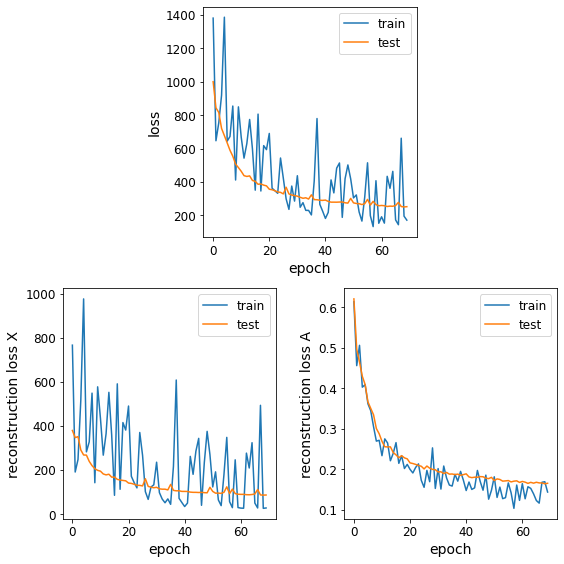

In [120]:
def get_learning_progress_plot(df,model_names):
    ae_type= "GAE"
    row = df.loc[df['ae_type']=="{0}".format(ae_type)]
    row = row.loc[np.min(row['mean_loss_test']) == row['mean_loss_test']]
    print(row)
    losses_all_test = row['losses_all_test'].values[0]
    losses_all_train = row['losses_all_train'].values[0]
    
    test_loss_all = [x[0] for x in  losses_all_test]
    test_reconstruction_loss = [x[1] for x in  losses_all_test]
    test_reconstruction_lossA = [x[2] for x in  losses_all_test]
    test_reconstruction_lossX = [x[3] for x in  losses_all_test]
    if row['ae_type'].values[0] == "VGAE":   
        test_kl_loss = [x[4] for x in  losses_all_test]
        
    train_loss_all = [x[0] for x in  losses_all_train]
    train_reconstruction_loss = [x[1] for x in  losses_all_train]
    train_reconstruction_lossA = [x[2] for x in  losses_all_train]
    train_reconstruction_lossX = [x[3] for x in  losses_all_train]
    if row['ae_type'].values[0] == "VGAE":   
        train_kl_loss = [x[4] for x in  losses_all_train]
    
    
    if row['ae_type'].values[0] == "VGAE":
        fig = plt.figure(figsize=(8,10))
        
        gs = gridspec.GridSpec(3, 4)
        
        ax1 = plt.subplot(gs[0, 0:2])
        x_train = np.array(train_loss_all)
        x_test = np.array(test_loss_all)
        ax1.plot(x_train, label = "train")
        ax1.plot(x_test, label = "test")
        ax1.set(xlabel='epoch', ylabel='loss')
        ax1.legend()
        
        ax2 = plt.subplot(gs[0,2:])
        x_train = np.array(train_reconstruction_loss)
        x_test = np.array(test_reconstruction_loss)
        ax2.plot(x_train, label = "train")
        ax2.plot(x_test, label = "test")
        ax2.set(xlabel='epoch', ylabel='reconstruction loss')
        ax2.legend()

        ax3 = plt.subplot(gs[1,0:2])
        x_train = np.array(train_reconstruction_lossX)
        x_test = np.array(test_reconstruction_lossX)
        ax3.plot(x_train, label = "train")
        ax3.plot(x_test, label = "test")
        ax3.set(xlabel='epoch', ylabel='reconstruction loss X')
        ax3.legend()
        
        ax4 = plt.subplot(gs[1,2:])
        x_train = np.array(train_reconstruction_lossA)
        x_test = np.array(test_reconstruction_lossA)
        ax4.plot(x_train, label = "train")
        ax4.plot(x_test, label = "test")
        ax4.set(xlabel='epoch', ylabel='reconstruction loss A')
        ax4.legend()
        
        x_train = np.array(train_kl_loss)
        x_test = np.array(test_kl_loss)
        ax5 = plt.subplot(gs[2,1:3])
        ax5.plot(x_train, label = "train")
        ax5.plot(x_test, label = "test")
        ax5.set(xlabel='epoch', ylabel='kl loss')
        gs.tight_layout(fig)
        ax_lst = [ax1,ax2,ax3,ax4,ax5]

    else:
        fig = plt.figure(figsize=(8,8))
        
        gs = gridspec.GridSpec(2, 4)
        
        ax1 = plt.subplot(gs[0, 1:3])
        x_train = np.array(train_loss_all)
        x_test = np.array(test_loss_all)
        ax1.plot(x_train, label = "train")
        ax1.plot(x_test, label = "test")
        ax1.set(xlabel='epoch', ylabel='loss')
        ax1.legend()
        
#         ax2 = plt.subplot(gs[0,2:])
#         x_train = np.array(train_reconstruction_loss)
#         x_test = np.array(test_reconstruction_loss)
#         ax2.plot(x_train, label = "train")
#         ax2.plot(x_test, label = "test")
#         ax2.set(xlabel='epoch', ylabel='reconstruction loss')
#         ax2.legend()

        ax3 = plt.subplot(gs[1,0:2])
        x_train = np.array(train_reconstruction_lossX)
        x_test = np.array(test_reconstruction_lossX)
        ax3.plot(x_train, label = "train")
        ax3.plot(x_test, label = "test")
        ax3.set(xlabel='epoch', ylabel='reconstruction loss X')
        ax3.legend()
        
        ax4 = plt.subplot(gs[1,2:])
        x_train = np.array(train_reconstruction_lossA)
        x_test = np.array(test_reconstruction_lossA)
        ax4.plot(x_train, label = "train")
        ax4.plot(x_test, label = "test")
        ax4.set(xlabel='epoch', ylabel='reconstruction loss A')
        ax4.legend()
        
        gs.tight_layout(fig)
        ax_lst = [ax1,ax3,ax4]
        
    plt.savefig("{0}{1}_learning_progress_{2}.pdf".format(DATA_OUT,model_names,ae_type))
        
        
get_learning_progress_plot(finall_df,model_names)

VGAENo


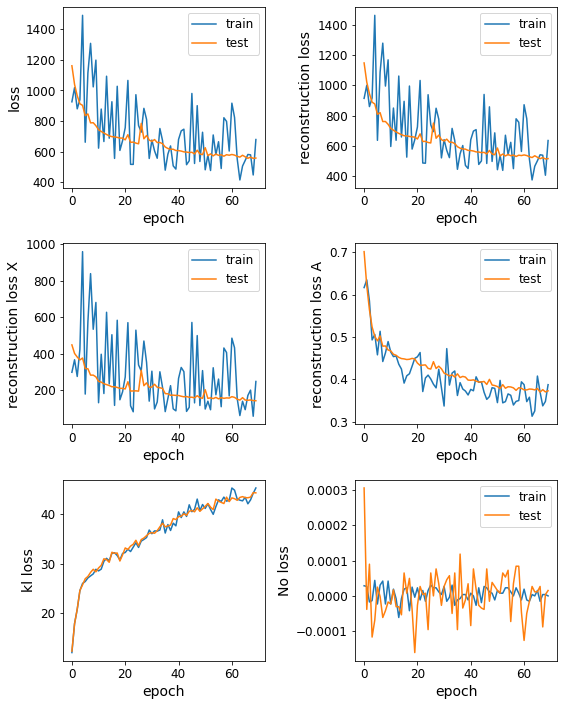

GAENo


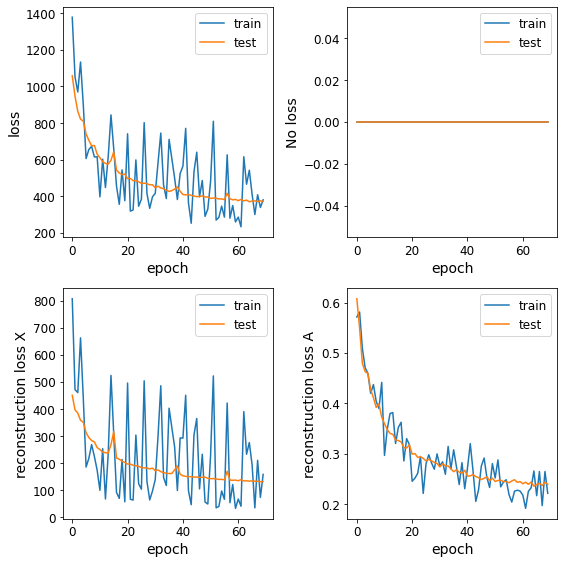

VGAENo


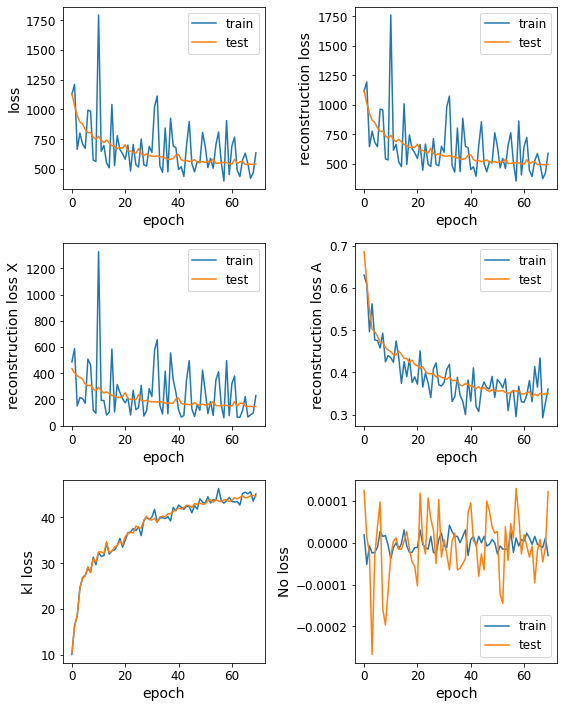

VGAENo


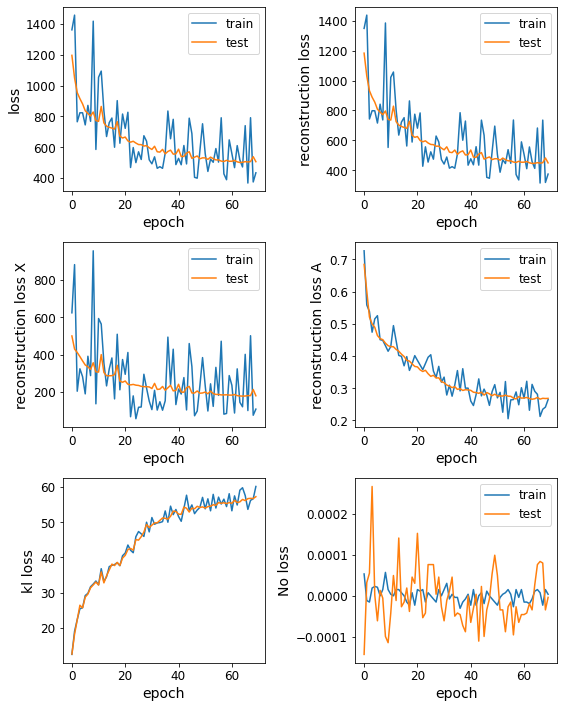

GAENo


KeyboardInterrupt: 

In [121]:
def get_learning_progress_plot(row,model_names):

    losses_all_test = row['losses_all_test']
    losses_all_train = row['losses_all_train']
    
    test_loss_all = [x[0] for x in  losses_all_test]
    test_reconstruction_loss = [x[1] for x in  losses_all_test]
    test_reconstruction_lossA = [x[2] for x in  losses_all_test]
    test_reconstruction_lossX = [x[3] for x in  losses_all_test]
    test_custom_loss = np.array(test_loss_all)-np.array(test_reconstruction_loss)
    if row['ae_type'] == "VGAE":   
        test_kl_loss = [x[4] for x in  losses_all_test]
        test_custom_loss = np.array(test_custom_loss) - np.array(test_kl_loss)
    train_loss_all = [x[0] for x in  losses_all_train]
    train_reconstruction_loss = [x[1] for x in  losses_all_train]
    train_reconstruction_lossA = [x[2] for x in  losses_all_train]
    train_reconstruction_lossX = [x[3] for x in  losses_all_train]
    train_custom_loss = np.array(train_loss_all)-np.array(train_reconstruction_loss)
    if row['ae_type'] == "VGAE":   
        train_kl_loss = [x[4] for x in  losses_all_train]
        train_custom_loss = np.array(train_custom_loss) - np.array(train_kl_loss)
    
    if row['ae_type'] == "VGAE":
        fig = plt.figure(figsize=(8,10))
        
        gs = gridspec.GridSpec(3, 4)
        
        ax1 = plt.subplot(gs[0, 0:2])
        x_train = np.array(train_loss_all)
        x_test = np.array(test_loss_all)
        ax1.plot(x_train, label = "train")
        ax1.plot(x_test, label = "test")
        ax1.set(xlabel='epoch', ylabel='loss')
        ax1.legend()
        
        ax2 = plt.subplot(gs[0,2:])
        x_train = np.array(train_reconstruction_loss)
        x_test = np.array(test_reconstruction_loss)
        ax2.plot(x_train, label = "train")
        ax2.plot(x_test, label = "test")
        ax2.set(xlabel='epoch', ylabel='reconstruction loss')
        ax2.legend()

        ax3 = plt.subplot(gs[1,0:2])
        x_train = np.array(train_reconstruction_lossX)
        x_test = np.array(test_reconstruction_lossX)
        ax3.plot(x_train, label = "train")
        ax3.plot(x_test, label = "test")
        ax3.set(xlabel='epoch', ylabel='reconstruction loss X')
        ax3.legend()
        
        ax4 = plt.subplot(gs[1,2:])
        x_train = np.array(train_reconstruction_lossA)
        x_test = np.array(test_reconstruction_lossA)
        ax4.plot(x_train, label = "train")
        ax4.plot(x_test, label = "test")
        ax4.set(xlabel='epoch', ylabel='reconstruction loss A')
        ax4.legend()
        
        x_train = np.array(train_kl_loss)
        x_test = np.array(test_kl_loss)
        ax5 = plt.subplot(gs[2,0:2])
        ax5.plot(x_train, label = "train")
        ax5.plot(x_test, label = "test")
        ax5.set(xlabel='epoch', ylabel='kl loss')
        
        ax2 = plt.subplot(gs[2,2:])
        x_train = np.array(train_custom_loss)
        x_test = np.array(test_custom_loss)
        ax2.plot(x_train, label = "train")
        ax2.plot(x_test, label = "test")
        ax2.set(xlabel='epoch',  ylabel='{0}'.format(row['loss_type']+" loss"))
        ax2.legend()
        
        gs.tight_layout(fig)
        
        ax_lst = [ax1,ax2,ax3,ax4,ax5]

    else:
        fig = plt.figure(figsize=(8,8))
        
        gs = gridspec.GridSpec(2, 4)
        
        ax1 = plt.subplot(gs[0, 0:2])
        x_train = np.array(train_loss_all)
        x_test = np.array(test_loss_all)
        ax1.plot(x_train, label = "train")
        ax1.plot(x_test, label = "test")
        ax1.set(xlabel='epoch', ylabel='loss')
        ax1.legend()
        
        ax2 = plt.subplot(gs[0,2:])
        x_train = np.array(train_custom_loss)
        x_test = np.array(test_custom_loss)
        ax2.plot(x_train, label = "train")
        ax2.plot(x_test, label = "test")
        ax2.set(xlabel='epoch', ylabel='{0}'.format(row['loss_type']+" loss"))
        ax2.legend()

        ax3 = plt.subplot(gs[1,0:2])
        x_train = np.array(train_reconstruction_lossX)
        x_test = np.array(test_reconstruction_lossX)
        ax3.plot(x_train, label = "train")
        ax3.plot(x_test, label = "test")
        ax3.set(xlabel='epoch', ylabel='reconstruction loss X')
        ax3.legend()
        
        ax4 = plt.subplot(gs[1,2:])
        x_train = np.array(train_reconstruction_lossA)
        x_test = np.array(test_reconstruction_lossA)
        ax4.plot(x_train, label = "train")
        ax4.plot(x_test, label = "test")
        ax4.set(xlabel='epoch', ylabel='reconstruction loss A')
        ax4.legend()
        
        gs.tight_layout(fig)
        ax_lst = [ax1,ax2,ax3,ax4]
    plt.tight_layout
    plt.savefig("{0}trainingvertpos/{1}_learning_progress_{2}.pdf".format(DATA_OUT,model_names,ae_type))
    plt.show()

temp_df = finall_df.loc[finall_df['latentdim']=="15"]
for idx,row in temp_df.iterrows():
    print(row['ae_type']+row['loss_type'])
    get_learning_progress_plot(row,model_names+row['ae_type']+row['loss_type'])

In [ ]:
temp_df['path'].values[0]

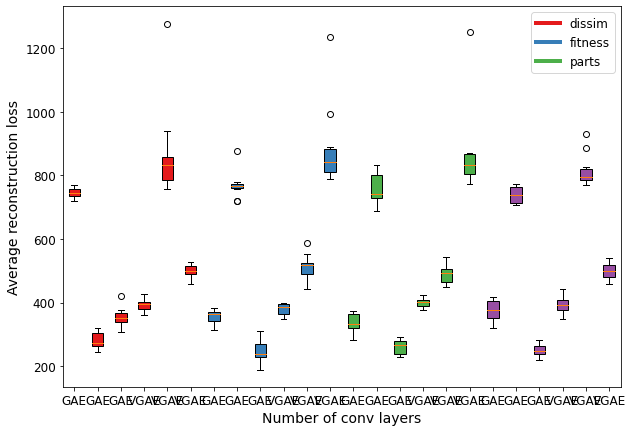

In [89]:
def get_best_for_fitness(df_models,name):
    convtypes = set(df_models['convtype'])
    ae_types = set(df_models['ae_type'])

    fig, ax = plt.subplots(1,1,figsize=(10,7), sharey=True)
    counter = 0
    pc_all = []
#     dim_data = df_models.loc[df_models['latentdim']==str(dim)]
    gae_data = df_models.sort_values(by=["loss_type",'ae_type'])


    color_labels = gae_data['loss_type'].unique()
    rgb_values = sns.color_palette("Set1", 4)
#         print(rgb_values)
    color_map = dict(zip(color_labels, rgb_values))
#         colors1 = [rgb_values[0],rgb_values[0],rgb_values[1],rgb_values[1],rgb_values[2],rgb_values[2],rgb_values[3],rgb_values[3]]
#         colors2 = ['red','red','green','green','blue','blue','yellow','yellow']
#     ax.bar(x=gae_data['path'], height=gae_data['mean_loss_test'],yerr=gae_data['std_loss_test'],color=gae_data['convenc'].map(color_map))
    bplot1 = ax.boxplot(gae_data['losses_test'],
#                      notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=gae_data['name'])  # will be used to label x-ticks
#     ax.bar(x=gae_data['path'], height=gae_data['mean_loss_train'],yerr=gae_data['std_loss_train'],color=gae_data['convenc'].map(color_map))
#     ax.title.set_text('Comparison of diferent layers settings')
    # fill with colors
    colors = gae_data['loss_type'].map(color_map)
#     print(colors)
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_xticklabels(gae_data['ae_type'])
#         handles0, labels0 = ax[0][counter].get_legend_handles_labels()
#         handles1, labels1 = ax[1][counter].get_legend_handles_labels()
    custom_lines = [Line2D([0], [0], color=rgb_values[0], lw=4),
                    Line2D([0], [0], color=rgb_values[1], lw=4),
                    Line2D([0], [0], color=rgb_values[2], lw=4),
#                         Line2D([0], [0], color=rgb_values[3], lw=4)
                   ]
    ax.set_xlabel('Number of conv layers')
    ax.legend(custom_lines, ['dissim', 'fitness', 'parts'])
    counter+=1

    x1 = list(gae_data['losses_test'])
    pc1 = sp.posthoc_nemenyi(x1)
    pc_all.append([pc1])

    ax.set_ylabel('Average reconstruction loss')
    plt.tight_layout
    plt.savefig("{0}{1}_loss_compairson.pdf".format(DATA_OUT,name))
    return pc_all
    
pc_all = get_best_for_fitness(finall_df,model_names)

In [90]:

# def get_best_for_layers2(df_models,name):
#     convtypes = set(df_models['convtype'])
#     ae_types = set(df_models['ae_type'])
#     latentdim = sorted([int(i) for i in set(df_models['convenc'])])
#     l = len(latentdim)
#     print(l)
#     fig, ax = plt.subplots(l,1,figsize=(10,6*l), sharey=True)
#     counter = 0
#     pc_all = []
#     for dim in latentdim:
#         print(dim)
#         dim_data = df_models.loc[df_models['convenc']==str(dim)]
#         gae_data = dim_data.loc[dim_data['ae_type']=="GAE"].sort_values(by=['denseenc','densedeca','convdecx','densedecx'])
#         color_labels = dim_data['densedeca'].unique()
#         rgb_values = sns.color_palette("Set1", 4)
# #         colors1 = [rgb_values[0],rgb_values[0],rgb_values[1],rgb_values[1],rgb_values[2],rgb_values[2],rgb_values[3],rgb_values[3]]
# #         colors2 = ['red','red','green','green','blue','blue','yellow','yellow']
#         bplot1 = ax[counter].boxplot(gae_data['losses_test'],
# #                      notch=True,  # notch shape
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=gae_data['name'])  # will be used to label x-ticks
        
#         color_labels = gae_data['densedeca'].unique()
#         rgb_values = sns.color_palette("Set1", 2)        
#         color_map = dict(zip(color_labels, rgb_values))
        
#         colors = gae_data['densedeca'].map(color_map)
#         for patch, color in zip(bplot1['boxes'], colors):
#             patch.set_facecolor(color)
        
        
#         ax[counter].title.set_text('Additional conv layers in encoder:'+str(dim))        
#         ax[counter].set_xticklabels(gae_data['name'])
# #         handles0, labels0 = ax[0][counter].get_legend_handles_labels()
# #         handles1, labels1 = ax[1][counter].get_legend_handles_labels()
#         custom_lines = [Line2D([0], [0], color=rgb_values[0], lw=4),
#                         Line2D([0], [0], color=rgb_values[1], lw=4),
# #                         Line2D([0], [0], color=rgb_values[2], lw=4),
# #                         Line2D([0], [0], color=rgb_values[3], lw=4)
#                        ]
#         ax[counter].set_xlabel('Number of additional layers in decoder X')
#         ax[counter].legend(custom_lines, ['1 additional dense layers in dec A', '2 additional dense layers in dec A'])
# #         ax[counter].legend(custom_lines, ['ARMAConv', 'GATConv', 'GCNConv', 'GCSConv'])
#         ax[counter].set_ylabel('Average reconstruction loss')
#         counter+=1
    
#         x1 = list(gae_data['losses_test'])
#         pc1 = sp.posthoc_nemenyi(x1)
#         pc_all.append([pc1])
    
# #     ax[0].set_ylabel('Average reconstruction loss')
# #     ax[0].set_ylabel('Average reconstruction loss')
#     plt.tight_layout
#     plt.savefig("{0}{1}_compairson.pdf".format(DATA_OUT,name))
#     plt.show()
#     return pc_all
    
# pc_all = get_best_for_layers2(finall_df,model_names)
# # pc1 = sp.posthoc_nemenyi(finall_df['losses_test'].values)
# # heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
# # sp.sign_plot(pc1, **heatmap_args)
# # plt.savefig("{0}{1}_posthoc_nemenyi.pdf".format(DATA_OUT,model_names))
# # plt.show()

In [91]:
# for p in pc_all[0]:
#     heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
#     sp.sign_plot(p, **heatmap_args)
#     plt.show()
# # plt.savefig("fig.pdf")

In [92]:
# Best range for mutation operator has to offer the smallest possible non zero change in fitness value. 

3


AttributeError: 'numpy.ndarray' object has no attribute 'boxplot'

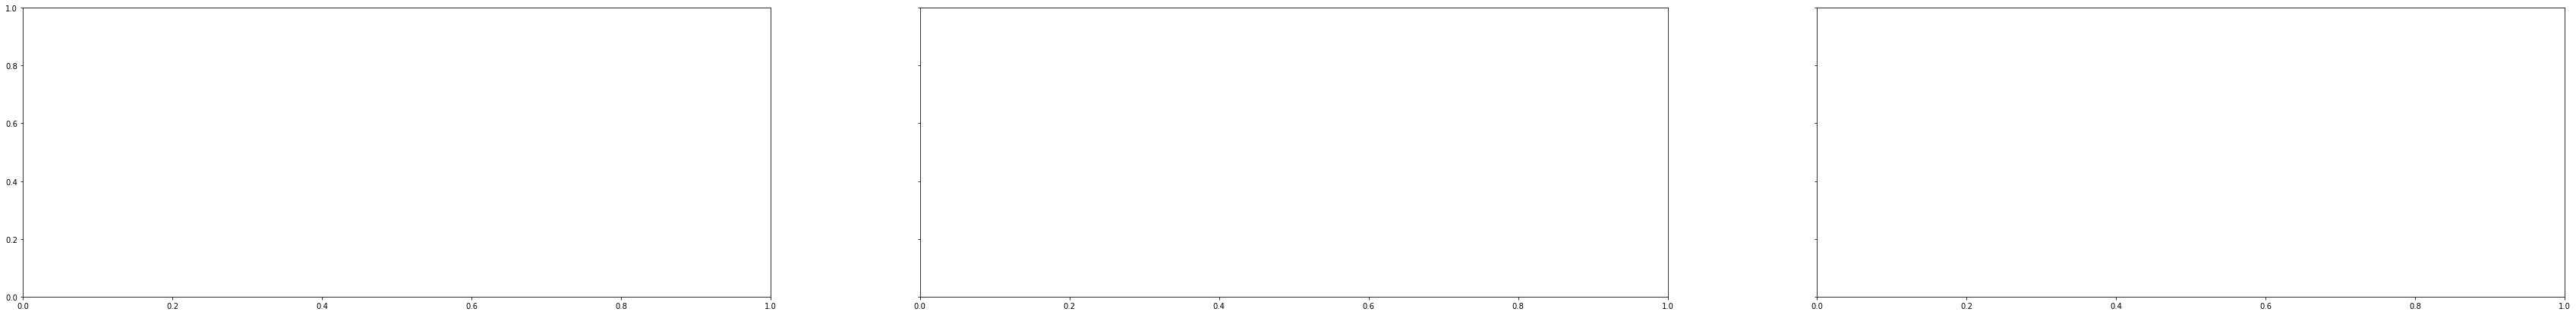

In [508]:
# def get_best_for_layers(df_models,name):
#     convtypes = set(df_models['convtype'])
#     ae_types = set(df_models['ae_type'])
#     latentdim = sorted([int(i) for i in set(df_models['latentdim'])])
#     l = len(latentdim)
#     print(l)
#     fig, ax = plt.subplots(1,l,figsize=(20*l,7), sharey=True)
#     counter = 0
#     pc_all = []
# #     dim_data = df_models.loc[df_models['latentdim']==str(dim)]
#     gae_data = df_models.sort_values(by=["convenc",'denseenc','densedeca','convdecx','densedecx'])


#     color_labels = gae_data['convenc'].unique()
#     rgb_values = sns.color_palette("Set1", 4)
# #         print(rgb_values)
#     color_map = dict(zip(color_labels, rgb_values))
# #         colors1 = [rgb_values[0],rgb_values[0],rgb_values[1],rgb_values[1],rgb_values[2],rgb_values[2],rgb_values[3],rgb_values[3]]
# #         colors2 = ['red','red','green','green','blue','blue','yellow','yellow']
# #     ax.bar(x=gae_data['path'], height=gae_data['mean_loss_test'],yerr=gae_data['std_loss_test'],color=gae_data['convenc'].map(color_map))
#     bplot1 = ax.boxplot(gae_data['losses_test'],
# #                      notch=True,  # notch shape
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=gae_data['name'])  # will be used to label x-ticks
# #     ax.bar(x=gae_data['path'], height=gae_data['mean_loss_train'],yerr=gae_data['std_loss_train'],color=gae_data['convenc'].map(color_map))
# #     ax.title.set_text('Comparison of diferent layers settings')
#     # fill with colors
#     colors = gae_data['convenc'].map(color_map)
# #     print(colors)
#     for patch, color in zip(bplot1['boxes'], colors):
#         patch.set_facecolor(color)
#     ax.set_xticklabels(gae_data['name'])
# #         handles0, labels0 = ax[0][counter].get_legend_handles_labels()
# #         handles1, labels1 = ax[1][counter].get_legend_handles_labels()
#     custom_lines = [Line2D([0], [0], color=rgb_values[0], lw=4),
#                     Line2D([0], [0], color=rgb_values[1], lw=4),
#                     Line2D([0], [0], color=rgb_values[2], lw=4),
# #                         Line2D([0], [0], color=rgb_values[3], lw=4)
#                    ]
#     ax.set_xlabel('Number of conv layers')
#     ax.legend(custom_lines, ['convenc1', 'convenc2', 'convenc3'])
#     counter+=1

#     x1 = list(gae_data['losses_test'])
#     pc1 = sp.posthoc_nemenyi(x1)
#     pc_all.append([pc1])

#     ax.set_ylabel('Average reconstruction loss')
#     plt.tight_layout
#     plt.savefig("{0}{1}_compairson.pdf".format(DATA_OUT,name))
#     return pc_all
    
# pc_all = get_best_for_layers(finall_df,model_names)

In [510]:
# from matplotlib.gridspec import SubplotSpec
# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(True)
#     row.axis('off')
    
# def get_best_for_convtype(df_models,name):
#     convtypes = set(df_models['convtype'])
#     ae_types = set(df_models['ae_type'])
#     latentdim = sorted([int(i) for i in set(df_models['latentdim'])])
#     l = len(latentdim)
#     print(l)
#     fig, ax = plt.subplots(l,2,figsize=(10,5*l), sharey=True)
    
#     plt.subplots_adjust(bottom=0.1,  top=0.9)
#     grid = plt.GridSpec(l, 2)
#     create_subtitle(fig, grid[0, ::], 'Latent space: 3')
#     create_subtitle(fig, grid[1, ::], 'Latent space: 10')
#     create_subtitle(fig, grid[2, ::], 'Latent space: 15')

#     counter = 0
#     pc_all = []
#     for dim in latentdim:
#         print(dim)
#         dim_data = df_models.loc[df_models['latentdim']==str(dim)]
#         gae_data = dim_data.loc[dim_data['ae_type']=="GAE"].sort_values(by="convtype")
#         vgae_data = dim_data.loc[dim_data['ae_type']=="VGAE"].sort_values(by="convtype")
# #         a_names= np.arange(len(dim_data['name'])-1)
# #         print(a_names)
# #         print(list(df_models['mean_loss_test']))
# #         colors = {'ARMAConv':'red', 'GATConv':'green', 'GCNConv':'blue', 'GCSConv':'yellow'}
#         color_labels = dim_data['convtype'].unique()
#         rgb_values = sns.color_palette("Set1", 4)
# #         print(rgb_values)
# #         color_map = dict(zip(color_labels, rgb_values))
#         colors1 = [rgb_values[0],rgb_values[0],rgb_values[1],rgb_values[1],rgb_values[2],rgb_values[2],rgb_values[3],rgb_values[3]]
#         colors2 = ['red','red','green','green','blue','blue','yellow','yellow']
        
# #         ax[0][counter].bar(x=gae_data['path'], height=gae_data['mean_loss_test'],yerr=gae_data['std_loss_test'],color=colors1)
# #         ax[1][counter].bar(x=vgae_data['path'], height=vgae_data['mean_loss_test'],yerr=vgae_data['std_loss_test'],color=colors1)#vgae_data['ae_type'].map(colors))
#         bplot1 = ax[counter][0].boxplot(gae_data['losses_test'],
# #                      notch=True,  # notch shape
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=gae_data['name'])  # will be used to label x-ticks
#         bplot2 = ax[counter][1].boxplot(vgae_data['losses_test'],
# #                      notch=True,  # notch shape
#                      vert=True,  # vertical box alignment
#                      patch_artist=True,  # fill with color
#                      labels=gae_data['name'])  # will be used to label x-ticks
        
#         color_labels = gae_data['convtype'].unique()
#         rgb_values = sns.color_palette("Set1", 4)        
#         color_map = dict(zip(color_labels, rgb_values))
        
#         colors = gae_data['convtype'].map(color_map)
#         for patch, color in zip(bplot1['boxes'], colors):
#             patch.set_facecolor(color)
        
#         colors = vgae_data['convtype'].map(color_map)
#         for patch, color in zip(bplot2['boxes'], colors):
#             patch.set_facecolor(color)
#         ax[counter][0].set_xticklabels(gae_data['convenc'])
#         ax[counter][1].set_xticklabels(vgae_data['convenc'])
# #         handles0, labels0 = ax[0][counter].get_legend_handles_labels()
# #         handles1, labels1 = ax[1][counter].get_legend_handles_labels()
#         custom_lines = [Line2D([0], [0], color=rgb_values[0], lw=4),
#                         Line2D([0], [0], color=rgb_values[1], lw=4),
#                         Line2D([0], [0], color=rgb_values[2], lw=4),
#                         Line2D([0], [0], color=rgb_values[3], lw=4)]
#         ax[counter][0].set_xlabel('Additional conv layers in encoder')
#         ax[counter][1].set_xlabel('Additional conv layers in encoder')
#         ax[counter][0].legend(custom_lines, ['ARMAConv', 'GATConv', 'GCNConv', 'GCSConv'])
#         ax[counter][1].legend(custom_lines, ['ARMAConv', 'GATConv', 'GCNConv', 'GCSConv'])
#         counter+=1
        
#         x1 = list(gae_data['losses_test'])
#         x2 = list(vgae_data['losses_test'])
#         pc1 = sp.posthoc_nemenyi(x1)
#         pc2 = sp.posthoc_nemenyi(x2)
#         pc_all.append([pc1,pc2])
    
#     ax[0][0].title.set_text('GAE')       
#     ax[0][1].title.set_text('VGAE')   
#     ax[1][0].set_ylabel('Average reconstruction loss')
#     ax[2][0].set_ylabel('Average reconstruction loss')
#     ax[0][0].set_ylabel('Average reconstruction loss')
#     plt.tight_layout
#     plt.savefig("{0}{1}_compairson.pdf".format(DATA_OUT,name))
#     return pc_all
    
# pc_all = get_best_for_convtype(finall_df,model_names)

3
3
10
15


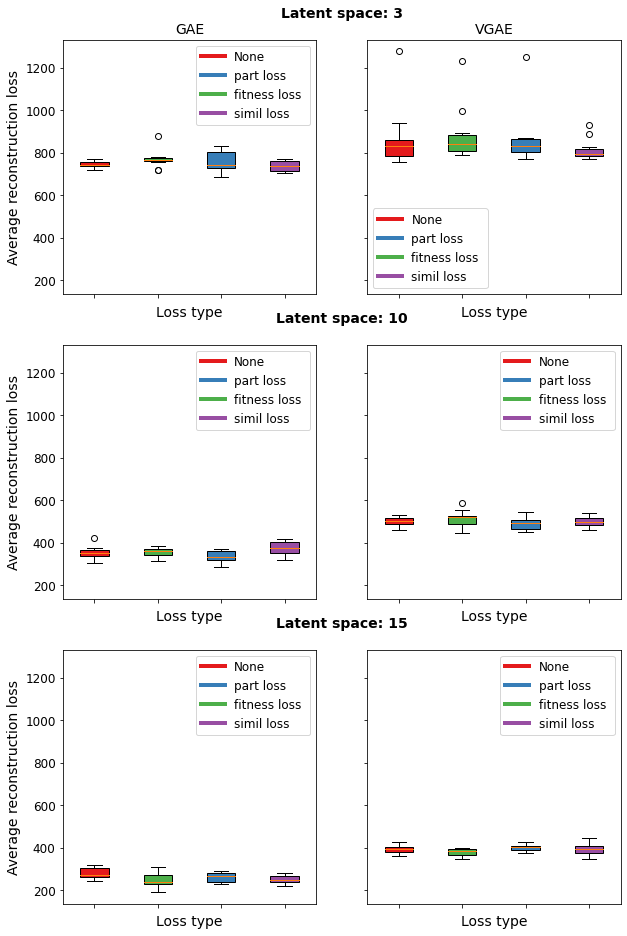

In [93]:
from matplotlib.gridspec import SubplotSpec
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(True)
    row.axis('off')
    
def get_best_for_loss_latent(df_models,name):

    latentdim = sorted([int(i) for i in set(df_models['latentdim'])])
    l = len(latentdim)
    print(l)
    fig, ax = plt.subplots(l,2,figsize=(10,5*l), sharey=True)
    
    plt.subplots_adjust(bottom=0.1,  top=0.9)

    grid = plt.GridSpec(l, 2)
    create_subtitle(fig, grid[0, ::], 'Latent space: 3')
    create_subtitle(fig, grid[1, ::], 'Latent space: 10')
    create_subtitle(fig, grid[2, ::], 'Latent space: 15')

    counter = 0
    pc_all = []
    
    color_labels = df_models['loss_type'].unique()
    rgb_values = sns.color_palette("Set1", 4)        
    color_map = dict(zip(color_labels, rgb_values))
    
    for dim in latentdim:
        print(dim)
        dim_data = df_models.loc[df_models['latentdim']==str(dim)]
        gae_data = dim_data.loc[dim_data['ae_type']=="GAE"].sort_values(by="loss_type")
        vgae_data = dim_data.loc[dim_data['ae_type']=="VGAE"].sort_values(by="loss_type")
#         a_names= np.arange(len(dim_data['name'])-1)
#         print(a_names)
#         print(list(df_models['mean_loss_test']))
#         colors = {'ARMAConv':'red', 'GATConv':'green', 'GCNConv':'blue', 'GCSConv':'yellow'}
#         color_labels = dim_data['loss_type'].unique()
#         rgb_values = sns.color_palette("Set1", 4)
#         print(rgb_values)
#         color_map = dict(zip(color_labels, rgb_values))
#         colors1 = [rgb_values[0],rgb_values[0],rgb_values[1],rgb_values[1],rgb_values[2],rgb_values[2],rgb_values[3],rgb_values[3]]
#         colors2 = ['red','red','green','green','blue','blue','yellow','yellow']
        
#         ax[0][counter].bar(x=gae_data['path'], height=gae_data['mean_loss_test'],yerr=gae_data['std_loss_test'],color=colors1)
#         ax[1][counter].bar(x=vgae_data['path'], height=vgae_data['mean_loss_test'],yerr=vgae_data['std_loss_test'],color=colors1)#vgae_data['ae_type'].map(colors))
        bplot1 = ax[counter][0].boxplot(gae_data['losses_test'],
#                      notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=gae_data['name'])  # will be used to label x-ticks
        bplot2 = ax[counter][1].boxplot(vgae_data['losses_test'],
#                      notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=gae_data['name'])  # will be used to label x-ticks
        

        colors = gae_data['loss_type'].map(color_map)
        for patch, color in zip(bplot1['boxes'], colors):
            patch.set_facecolor(color)
        
        colors = vgae_data['loss_type'].map(color_map)
        for patch, color in zip(bplot2['boxes'], colors):
            patch.set_facecolor(color)
        ax[counter][0].set_xticklabels([])
        ax[counter][1].set_xticklabels([])
#         handles0, labels0 = ax[0][counter].get_legend_handles_labels()
#         handles1, labels1 = ax[1][counter].get_legend_handles_labels()
        custom_lines = [Line2D([0], [0], color=rgb_values[0], lw=4),
                        Line2D([0], [0], color=rgb_values[1], lw=4),
                        Line2D([0], [0], color=rgb_values[2], lw=4),
                        Line2D([0], [0], color=rgb_values[3], lw=4)]
        ax[counter][0].set_xlabel('Loss type')
        ax[counter][1].set_xlabel('Loss type')
        ax[counter][0].legend(custom_lines, ['None', 'part loss', 'fitness loss ', 'simil loss'])
        ax[counter][1].legend(custom_lines, ['None', 'part loss', 'fitness loss ', 'simil loss'])
        counter+=1
        
        x1 = list(gae_data['losses_test'])
        x2 = list(vgae_data['losses_test'])
        pc1 = sp.posthoc_nemenyi(x1)
        pc2 = sp.posthoc_nemenyi(x2)
        pc_all.append([pc1,pc2])
   

    ax[0][0].title.set_text('GAE')       
    ax[0][1].title.set_text('VGAE')   
    ax[1][0].set_ylabel('Average reconstruction loss')
    ax[2][0].set_ylabel('Average reconstruction loss')
    ax[0][0].set_ylabel('Average reconstruction loss')
    plt.tight_layout 

    plt.savefig("{0}{1}_compairson.pdf".format(DATA_OUT,name))
    return pc_all
    
pc_all = get_best_for_loss_latent(finall_df,model_names)

In [94]:
# test =  list(finall_df.loc[finall_df['latentdim'] != '10'].loc[finall_df['ae_type']=="GAE"]['losses_test'])
# print(test)
# print(len(test))
# pc1 = sp.posthoc_nemenyi(test)
# heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
# sp.sign_plot(g, **heatmap_args)
# # plt.savefig("{0}{1}_posthoc_nemenyi.pdf".format(DATA_OUT,model_names))
# plt.show()

In [419]:
# def gen_bar_plot(fit,r,name="_"):
#     labels = np.arange(len(fit[0]))
#     fig = plt.figure()                                                               
#     ax = fig.gca()  #get current axes
#     for f in fit:
#         ax.plot(labels, f, 0.1)
# #     ax.bar(labels, fit, 0.1, align='center')
#     #Remove the default x-axis tick numbers and  
#     #use tick numbers of your own choosing:
#     ax.set_xticks(labels)
#     #Replace the tick numbers with strings:
#     ax.set_xticklabels(labels)
#     #Remove the default y-axis tick numbers and  
#     #use tick numbers of your own choosing:
#     # ax.set_yticks(ys)
#     plt.savefig('{0}fit_jumps{1}_{2}_{3}.pdf'.format(DATA_OUT,r[0],r[1],name))

In [420]:
# def gen_fitness_mutation_change(base_v,all_v,name="_"):    
#     plt.figure()
#     fig, ax = plt.subplots(1, 3,figsize=(15,5), sharey=True)    
#     vertpos_base = eval(list(base_v.iloc[:,1])[0])
#     parts_base = eval(list(base_v.iloc[:,2])[0])
#     joints_base = eval(list(base_v.iloc[:,3])[0])
#     mean_fit = {}
#     std_fit = {}
#     for index, row in all_v.iterrows():
#         shifted_data = eval(row[1])
#         shifted_vertpos = shifted_data[0]
#         shifted_parts = shifted_data[1]
#         shifted_joints = shifted_data[2]
#         shift_v = [abs(float(vertpos_base[e])-float(shifted_vertpos[e])) for e in range(len(vertpos_base))]
# #         print("min",min(shift_v))
# #         print("max",max(shift_v))

#         mean_fit[labels[index]]=np.mean(shift_v)
#         std_fit[labels[index]]=np.std(shift_v)
        
#     finall_mean = [mean_fit[o] for o in order]
#     finall_std = [std_fit[o] for o in order]
#     ax.set_title("name")
#     ax.set_ylabel('Change in fitness')
#     ax.set_xlabel('Strength of mutation')
#     ax.bar(x=order, height=finall_mean,yerr=finall_std,width=0.5)
# #     plt.yscale('log')
#     plt.show()

AVG BASEbase_all_convtypes1_2_1_1_2_VGAE_No_15: 0.017223036460055942 0.013719681255712622


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

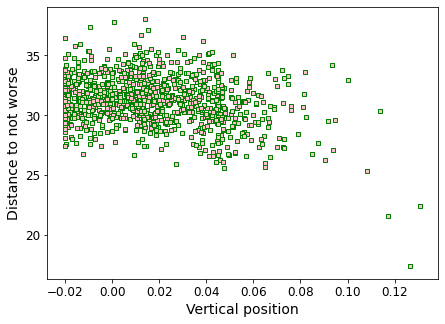

AVG BASEbase_all_convtypes1_2_1_1_2_VGAE_No_15: 0.02868669833188258 0.034247971533028033


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

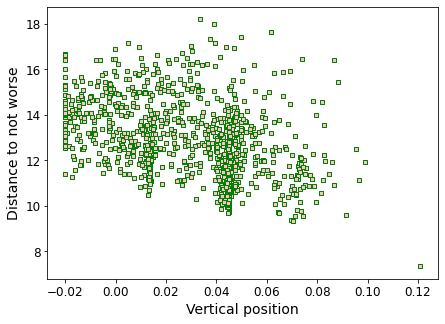

AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_15: 0.03809270872033784 0.03696819600470069


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

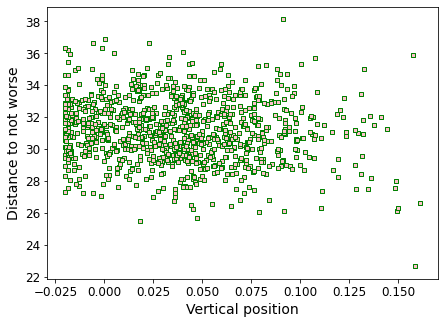

AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_15: 0.03749481020612359 0.044967580468329556


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

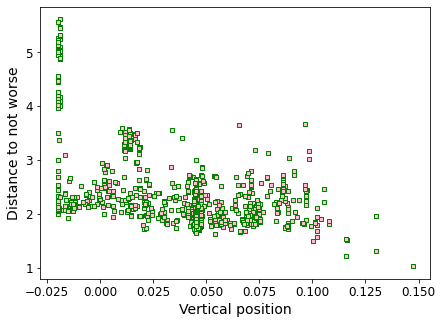

AVG BASEbase_all_convtypes1_2_1_1_2_VGAE_No_10: 0.01872883773080461 0.01799533879790121


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

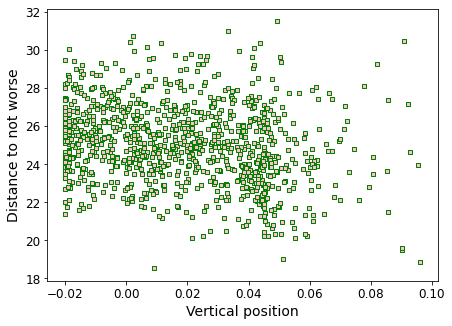

AVG BASEbase_all_convtypes1_2_1_1_2_VGAE_No_10: 0.02555760825102378 0.028734232846147317


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

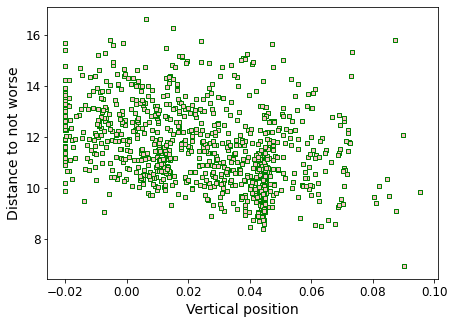

AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_10: 0.03755893554033944 0.03580839602879689


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

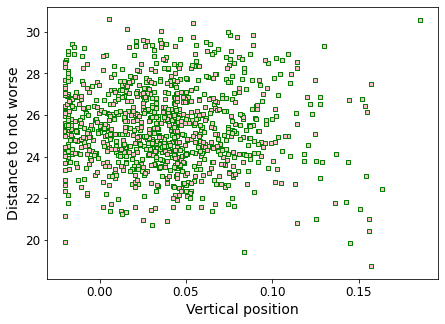

AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_10: 0.03568289702836732 0.04316402217091735


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

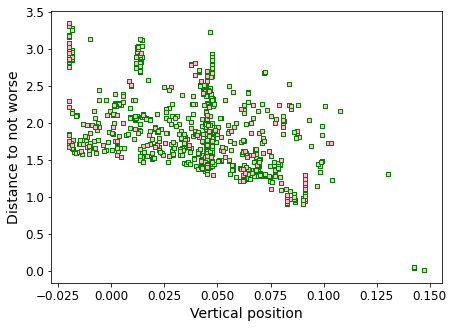

AVG BASEbase_all_convtypes2_2_1_1_2_VGAE_No_3: 0.009986453420315048 0.012287066427498852


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

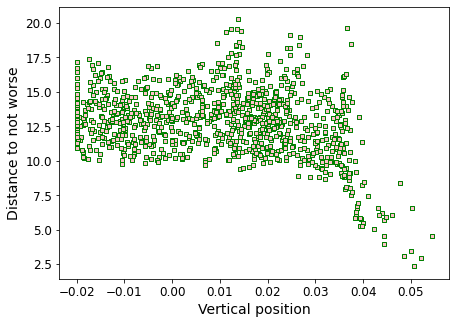

AVG BASEbase_all_convtypes2_2_1_1_2_VGAE_No_3: 0.00622426814273177 0.010013769314637436


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

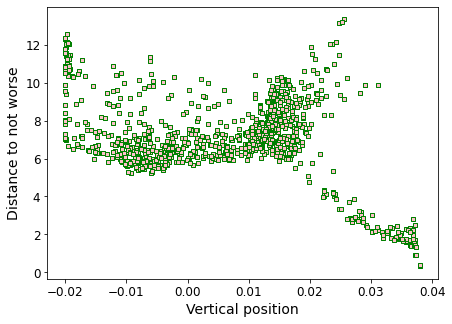

AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_3: 0.028352487388156437 0.022374738406509262


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

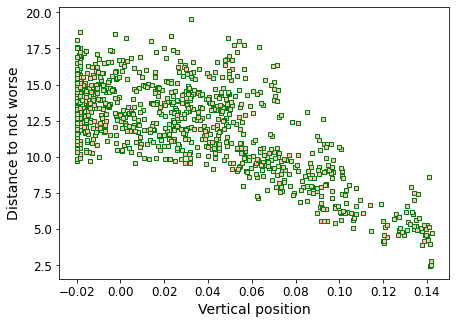

AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_3: 0.007342837623526991 0.006949550263540138


/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

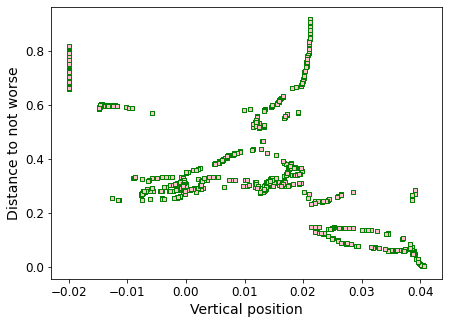

In [122]:
def gen_distance_to_not_worse(base_v,name,description):
    plt.figure()
    fig, ax = plt.subplots(1, 1,figsize=(7,5), sharey=True)
    
    vertpos_base = np.array(eval(list(base_v.iloc[:,1])[0]))
    print("AVG BASE{0}:".format(name),np.mean(vertpos_base),np.median(vertpos_base))

    parts_base = np.array(eval(list(base_v.iloc[:,2])[0]))
    joints_base = np.array(eval(list(base_v.iloc[:,3])[0]))
    z_base = np.array(eval(list(base_v.iloc[:,4])[0]))
    mean_fit = {}
    std_fit = {}
    shift_all = []
    mean_dist_all = []
    for i in range(len(vertpos_base)):
        bigger = np.argwhere(vertpos_base > vertpos_base[i])
        z = z_base[i]
#         print(z)
        dist_temp = []
        for b in bigger:
            if b!=i:
                dist = distance.euclidean(z,z_base[b])
                dist_temp.append(dist)
        mean_dist_all.append(np.mean(dist_temp))
#     print(mean_dist_all)


    plt.scatter(vertpos_base, mean_dist_all, c ="pink",
                linewidths = 1,
                marker ="s",
                edgecolor ="green",
                s = 20)

#     ax.set_title(description)
    ax.set_ylabel('Distance to not worse')
    ax.set_xlabel('Vertical position')
#     labels, data = dict1.keys(), dict1.values()
#     ax.bar(x=order, height=finall_mean,yerr=finall_std,width=0.5)

    plt.tight_layout
    plt.savefig("{0}/locality/{1}_dist_to_not_worse.pdf".format(DATA_OUT,name+description.replace(' ', '')))
    plt.show()
for i in range(len(paths)) :
#     print()
    p = paths[i]
    n = names[i]
#     p = "/home/adam/thesis/VGAE/experiments/experiment_base/models/No/GAE/numfeatures3/adjsize15/batchsize256/latentdim10/nhidden64/learningrate0.01/convtypeARMAConv/model_enc_2_2_deca1_decx1_2_train_id_9"
    all_v = pd.read_csv(p+"/pd_random_val_all.csv")  #pd_val_all.to_csv(p+"/pd_random_val_all.csv")
    base_v = pd.read_csv(p+"/pd_random_base.csv")  #pd_base.to_csv(p+"/pd_random_base.csv")
    gen_distance_to_not_worse(base_v,model_names+n,"Random samples from latent space")
    all_v = pd.read_csv(p+"/pd_val_all.csv")  #pd_val_all.to_csv(p+"/pd_random_val_all.csv")
    base_v = pd.read_csv(p+"/pd_base.csv")  #pd_base.to_csv(p+"/pd_random_base.csv")
    gen_distance_to_not_worse(base_v,model_names+n,"Random samples from training set")
#     break

/home/adam/thesis/VGAE/experiments/experiment_base/models/No/VGAE/numfeatures3/adjsize15/batchsize256/latentdim15/nhidden64/learningrate0.01/convtypeGCSConv/model_enc_1_2_deca1_decx1_2_train_id_6
STARTING
AVG BASEbase_all_convtypes1_2_1_1_2_VGAE_No_15: 0.017223036460055942 0.013719681255712622


<Figure size 432x288 with 0 Axes>

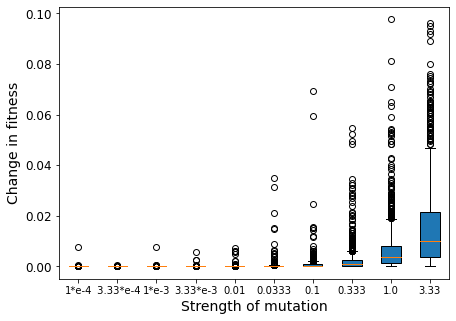

STARTING
AVG BASEbase_all_convtypes1_2_1_1_2_VGAE_No_15: 0.02868669833188258 0.034247971533028033


<Figure size 432x288 with 0 Axes>

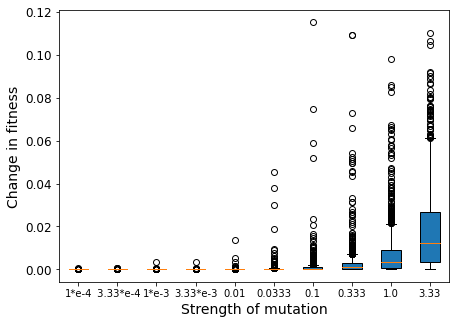

/home/adam/thesis/VGAE/experiments/experiment_base/models/No/GAE/numfeatures3/adjsize15/batchsize256/latentdim15/nhidden64/learningrate0.01/convtypeGCSConv/model_enc_2_2_deca1_decx1_2_train_id_8
STARTING
AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_15: 0.03809270872033784 0.03696819600470069


<Figure size 432x288 with 0 Axes>

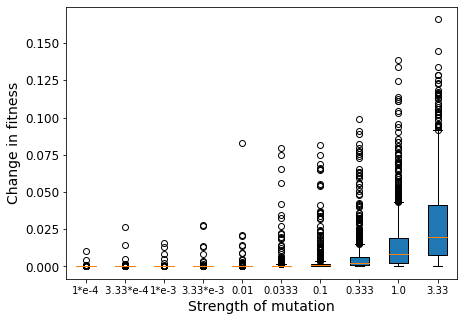

STARTING
AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_15: 0.03749481020612359 0.044967580468329556


<Figure size 432x288 with 0 Axes>

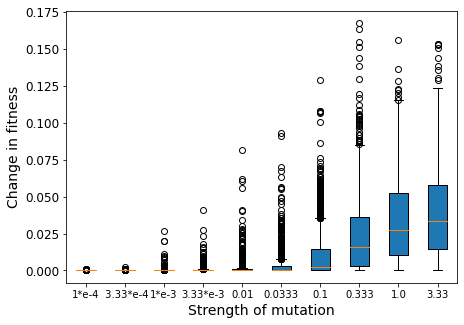

/home/adam/thesis/VGAE/experiments/experiment_base/models/No/VGAE/numfeatures3/adjsize15/batchsize256/latentdim10/nhidden64/learningrate0.01/convtypeGCSConv/model_enc_1_2_deca1_decx1_2_train_id_6
STARTING
AVG BASEbase_all_convtypes1_2_1_1_2_VGAE_No_10: 0.01872883773080461 0.01799533879790121


<Figure size 432x288 with 0 Axes>

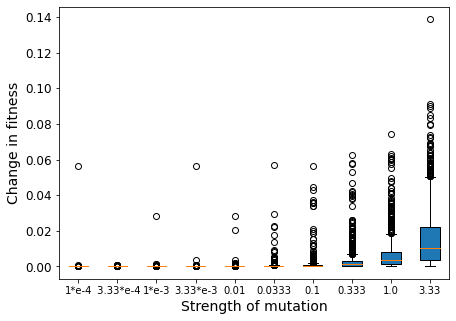

STARTING
AVG BASEbase_all_convtypes1_2_1_1_2_VGAE_No_10: 0.02555760825102378 0.028734232846147317


<Figure size 432x288 with 0 Axes>

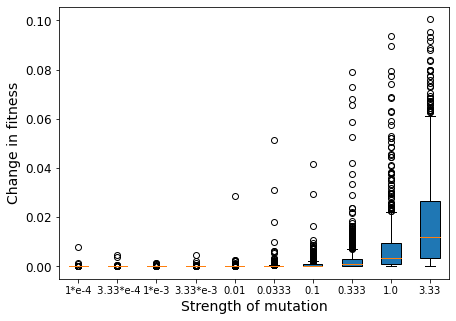

/home/adam/thesis/VGAE/experiments/experiment_base/models/No/GAE/numfeatures3/adjsize15/batchsize256/latentdim10/nhidden64/learningrate0.01/convtypeARMAConv/model_enc_2_2_deca1_decx1_2_train_id_9
STARTING
AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_10: 0.03755893554033944 0.03580839602879689


<Figure size 432x288 with 0 Axes>

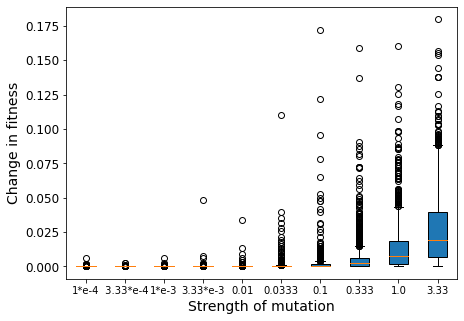

STARTING
AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_10: 0.03568289702836732 0.04316402217091735


<Figure size 432x288 with 0 Axes>

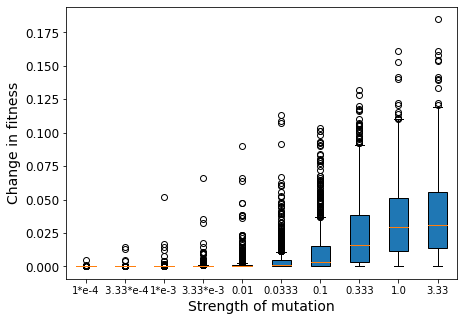

/home/adam/thesis/VGAE/experiments/experiment_base/models/No/VGAE/numfeatures3/adjsize15/batchsize256/latentdim3/nhidden64/learningrate0.01/convtypeARMAConv/model_enc_2_2_deca1_decx1_2_train_id_2
STARTING
AVG BASEbase_all_convtypes2_2_1_1_2_VGAE_No_3: 0.009986453420315048 0.012287066427498852


<Figure size 432x288 with 0 Axes>

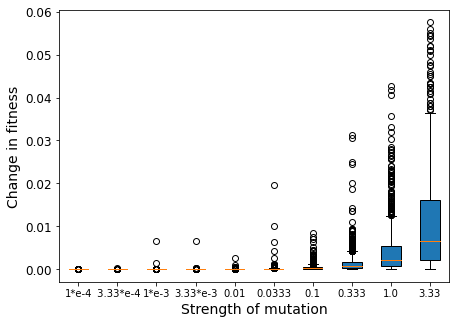

STARTING
AVG BASEbase_all_convtypes2_2_1_1_2_VGAE_No_3: 0.00622426814273177 0.010013769314637436


<Figure size 432x288 with 0 Axes>

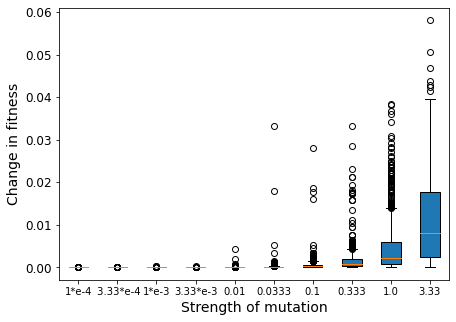

/home/adam/thesis/VGAE/experiments/experiment_base/models/No/GAE/numfeatures3/adjsize15/batchsize256/latentdim3/nhidden64/learningrate0.01/convtypeGCNConv/model_enc_2_2_deca1_decx1_2_train_id_6
STARTING
AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_3: 0.028352487388156437 0.022374738406509262


<Figure size 432x288 with 0 Axes>

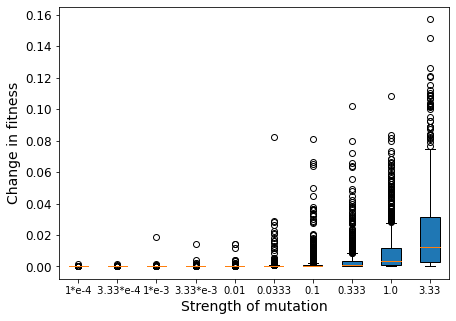

STARTING
AVG BASEbase_all_convtypes2_2_1_1_2_GAE_No_3: 0.007342837623526991 0.006949550263540138


<Figure size 432x288 with 0 Axes>

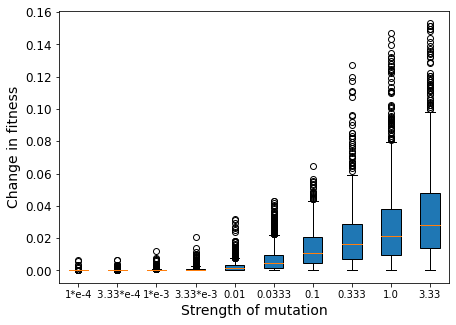

In [125]:
def gen_fitness_mutation_change(base_v,all_v,name,description):
    print("STARTING")
    order = ["0.0001","0.000333","0.001","0.00333","0.01","0.0333","0.1","0.333",'1.0',"3.333"]

    labels = [str(v) for v in list(all_v.iloc[:,0])]
    labels_f = ["1*e-4"," 3.33*e-4","1*e-3","3.33*e-3","0.01","0.0333","0.1","0.333",'1.0',"3.33"]
#     print(labels)
    plt.figure()
    fig, ax = plt.subplots(1, 1,figsize=(7,5), sharey=True)
    
    vertpos_base = eval(list(base_v.iloc[:,1])[0])
    print("AVG BASE{0}:".format(name),np.mean(vertpos_base),np.median(vertpos_base))
    parts_base = eval(list(base_v.iloc[:,2])[0])
    joints_base = eval(list(base_v.iloc[:,3])[0])
    mean_fit = {}
    median_fit = {}
    std_fit = {}
    shift_all = []
    labels_all = []
#     print(all_v)
    for index, row in all_v.iterrows():
        mod_string = row[1]
        shifted_data = eval(mod_string)
        shifted_vertpos = shifted_data[0]
        shifted_parts = shifted_data[1]
        shifted_joints = shifted_data[2]
        shift_v = [abs(float(vertpos_base[e])-float(shifted_vertpos[e])) for e in range(len(vertpos_base))]
        
        median_fit[str(labels[index])]=np.median(shift_v)
        mean_fit[str(labels[index])]=np.mean(shift_v)
        std_fit[str(labels[index])]=np.std(shift_v)
        shift_all.append(shift_v)
        labels_all.append(labels[index])
    
    
    finall_mean = [mean_fit[o] for o in order]
    finall_std = [std_fit[o] for o in order]
#     print("mean_fit",mean_fit)
#     print("std_fit",std_fit)
#     print("median_fit",median_fit)
#     ax.set_title(description)
    ax.set_ylabel('Change in fitness')
    ax.set_xlabel('Strength of mutation')
#     labels, data = dict1.keys(), dict1.values()
#     ax.bar(x=order, height=finall_mean,yerr=finall_std,width=0.5)
    bplot = ax.boxplot(shift_all,
#                      notch=True,  # notch shape
                 vert=True,  # vertical box alignment
                 patch_artist=True,  # fill with color
                 labels=labels_f)  # will be used to label x-ticks
    
#     bplot = ax.violinplot(shift_all,
# #                      notch=True,  # notch shape
#                  vert=True,  # vertical box alignment
# #                  patch_artist=True,  # fill with color
# #                  labels=labels_all
#                          )  # will be used to label x-ticks
    
    plt.tight_layout
    plt.savefig("{0}/mutation/{1}_mutation_s.pdf".format(DATA_OUT,name+description.replace(' ', '')))
    plt.show()


for i in range(len(paths)) :
#     print()
    p = paths[i]
    print(p)
    n = names[i]
#     p = "/home/adam/thesis/VGAE/experiments/experiment_base/models/No/GAE/numfeatures3/adjsize15/batchsize256/latentdim10/nhidden64/learningrate0.01/convtypeARMAConv/model_enc_2_2_deca1_decx1_2_train_id_9"
    all_v = pd.read_csv(p+"/pd_random_val_all.csv")  #pd_val_all.to_csv(p+"/pd_random_val_all.csv")
    base_v = pd.read_csv(p+"/pd_random_base.csv")  #pd_base.to_csv(p+"/pd_random_base.csv")
    gen_fitness_mutation_change(base_v,all_v,model_names+n,"Random samples from latent space")
    all_v = pd.read_csv(p+"/pd_val_all.csv")  #pd_val_all.to_csv(p+"/pd_random_val_all.csv")
    base_v = pd.read_csv(p+"/pd_base.csv")  #pd_base.to_csv(p+"/pd_random_base.csv")
    gen_fitness_mutation_change(base_v,all_v,model_names+n,"Random samples from training set")
#     break
#     try:
# #         print(p)
#         all_v = pd.read_csv(p+"/pd_random_val_all.csv")  #pd_val_all.to_csv(p+"/pd_random_val_all.csv")
#         base_v = pd.read_csv(p+"/pd_random_base.csv")  #pd_base.to_csv(p+"/pd_random_base.csv")
#         gen_fitness_mutation_change(base_v,all_v,"vertpos_random")
#         all_v = pd.read_csv(p+"/pd_val_all.csv")  #pd_val_all.to_csv(p+"/pd_random_val_all.csv")
#         base_v = pd.read_csv(p+"/pd_base.csv")  #pd_base.to_csv(p+"/pd_random_base.csv")
#         gen_fitness_mutation_change(base_v,all_v,"vertpos_database")
#     except Exception as e:
#         print(e)
#         print("WRONG PATH",p)
#     break
#     for index, row in all_v.iterrows():
# #         print(len())
# #         print()
#         g=eval(row[1])
#         break
#     for index, row in base_v.iterrows():
# #         print(len())
# #         print()
#         b=eval(row[1])
#         break
#     break

In [388]:
# !ls /home/adam/thesis/VGAE/experiments/experiment_base/models/No/GAE/numfeatures3/adjsize15/batchsize256/latentdim3/nhidden64/learningrate0.01/convtypeGCNConv/model_enc_2_2_deca1_decx1_2_train_id_6


random sampling

In [389]:
# order = ["0.0001","0.000333","0.001","0.00333","0.01","0.0333","0.1","0.333",'1.0',"3.333"]

# r = order[6]
# np.set_printoptions(suppress=True)

# for p in finall_df['path_model']:
#     p="/home/adam/thesis/VGAE/experiments/experiment_base/models/No/GAE/numfeatures3/adjsize15/batchsize256/latentdim15/nhidden64/learningrate0.01/convtypeGCSConv/model_enc_2_2_deca1_decx1_2_train_id_9"
#     for r in [[0,1]]:#ranges:
#         print(r)
#         path = p+"/decoded_{0}_{1}.pkl".format(r[0],r[1])
#         df_all = pd.read_pickle(path)
#         frams_gen,z_all = gen_f0_from_df(df_all)
#         print(df_all['z'])
#         gen_correct = []
#         z_correct = []
#         for i in range(len(frams_gen)):
#             if i % 20 ==0:
#                 print(i)
#             gen = frams_gen[i]
#             z = z_all[i]
# #             print("check_consistency_for_gen")
#             gen = framsmanager.check_consistency_for_gen(gen)
#             if gen is not None:
# #                 print("reduce_joint_length_for_gen")
#                 gen = framsmanager.reduce_joint_length_for_gen(gen)
#             if gen is not None:
#                 gen_correct.append(gen)
#                 z_correct.append(z)
#         print((len(gen_correct)))
#         c = framsLib.evaluate(gen_correct)
#         for i in range(len(c)):
#             f_val = c[i]['evaluations'] ['']['vertpos']
#             print(f_val)
#             fit.append(f_val)
# #         gen_bar_plot(fit,r)
# #         gen_bar_plot(fit,r)
#         break

#     break

In [390]:
# a = np.random.uniform(-3,3,[2,10])
# for p in a:
#     print(pJednocześnie życzymy Panu powodzenia w dalszym poszukiwaniu pracy.Jednocześnie życzymy Panu powodzenia w dalszym poszukiwaniu pracy.)

In [391]:
# np.random.uniform(-3,3,2)

In [392]:
# path_config_folder = "/home/adam/thesis/VGAE/config_evol/"
# for c in  set(finall_df['convtype']):
#     for l in set(finall_df['latentdim']):
#         for a in set(finall_df['ae_type']):
#             f_df = finall_df.loc[finall_df['convtype']==c].loc[finall_df['latentdim']==l].loc[finall_df['ae_type']==a]
#             c = f_df.loc[f_df['loss_train']==min(f_df['loss_train'])]
# #             paths.append(f_df['path_model'])
# #             print(f_df.name.values[0])
# #             print(f_df['path_model'].values[0])
# #             f = open(path_config_folder+f_df.name.values[0], "w")
# #             f.write(f_df['path'].values[0]+ "/")
# #             f.close()

In [393]:
# sp.sign_plot(pc2, **heatmap_args)

In [142]:
set(finall_df['convtype'])

{'GCSConv'}

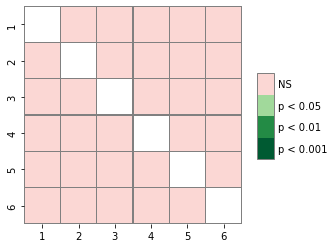

In [143]:
x = list(finall_df.loc[finall_df['convtype']=='GCSConv']['losses_train'])
pc = sp.posthoc_nemenyi(x)
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)
plt.savefig("fig.pdf")

In [53]:
pc

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000000,0.982351,0.979176,0.996776,1.000000,0.676631,1.000000,0.757354,0.984692,0.902500,0.700158,0.999420
2,0.982351,1.000000,1.000000,0.393862,0.982841,0.999933,0.999361,0.999988,0.246710,0.085447,0.021985,1.000000
3,0.979176,1.000000,1.000000,0.373361,0.979735,0.999955,0.999154,0.999993,0.230513,0.077852,0.019545,1.000000
4,0.996776,0.393862,0.373361,1.000000,0.996652,0.050024,0.953997,0.075442,1.000000,0.999994,0.999229,0.719789
5,1.000000,0.982841,0.979735,0.996652,1.000000,0.680030,1.000000,0.760374,0.984245,0.900718,0.696837,0.999447
6,0.676631,0.999933,0.999955,0.050024,0.680030,1.000000,0.911089,1.000000,0.021144,0.003750,0.000507,0.994820
7,1.000000,0.999361,0.999154,0.953997,1.000000,0.911089,1.000000,0.946294,0.883697,0.659459,0.380150,0.999999
8,0.757354,0.999988,0.999993,0.075442,0.760374,1.000000,0.946294,1.000000,0.033913,0.006670,0.000995,0.997988
9,0.984692,0.246710,0.230513,1.000000,0.984245,0.021144,0.883697,0.033913,1.000000,1.000000,0.999941,0.555732
10,0.902500,0.085447,0.077852,0.999994,0.900718,0.003750,0.659459,0.006670,1.000000,1.000000,1.000000,0.281018
